In [1]:
import json
import os
import random
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils.class_weight import compute_class_weight

pd.options.mode.chained_assignment = None

with open("../data/feature-meta/cleaned/meta.json") as f:
    feature_meta = json.load(f)

feature_meta

{'customerID': {'is_raw': True, 'type': 'ID'},
 'gender': {'is_raw': True, 'var_type': 'boolean', 'value_type': 'text'},
 'SeniorCitizen': {'is_raw': True,
  'var_type': 'boolean',
  'value_type': 'numeric'},
 'Partner': {'is_raw': True, 'var_type': 'boolean', 'value_type': 'text'},
 'Dependents': {'is_raw': True, 'var_type': 'boolean', 'value_type': 'text'},
 'tenure': {'is_raw': True, 'var_type': 'real', 'value_type': 'numeric'},
 'PhoneService': {'is_raw': True, 'var_type': 'boolean', 'value_type': 'text'},
 'MultipleLines': {'is_raw': True,
  'var_type': 'categorical',
  'value_type': 'text'},
 'InternetService': {'is_raw': True,
  'var_type': 'categorical',
  'value_type': 'text'},
 'OnlineSecurity': {'is_raw': True,
  'var_type': 'categorical',
  'value_type': 'text'},
 'OnlineBackup': {'is_raw': True,
  'var_type': 'categorical',
  'value_type': 'text'},
 'DeviceProtection': {'is_raw': True,
  'var_type': 'categorical',
  'value_type': 'text'},
 'TechSupport': {'is_raw': True,
 

In [2]:
x_train = pd.read_parquet("../data/featurized/x_train/data.parquet")
x_test = pd.read_parquet("../data/featurized/x_test/data.parquet")

In [3]:
y_train = pd.read_parquet("../data/featurized/y_train/data.parquet")
y_test = pd.read_parquet("../data/featurized/y_test/data.parquet")

In [4]:
x_train, x_cv, y_train, y_cv = train_test_split(
    x_train, y_train, test_size=0.2, shuffle=False
)

In [5]:
x_train.shape, x_cv.shape, x_test.shape

((4507, 34), (1127, 34), (1409, 34))

In [6]:
x_train.columns

Index(['PaymentMethod_0', 'PaymentMethod_1', 'PaymentMethod_2', 'Contract_0',
       'Contract_1', 'StreamingTV_0', 'StreamingTV_1', 'TechSupport_0',
       'TechSupport_1', 'DeviceProtection_0', 'DeviceProtection_1',
       'OnlineBackup_0', 'OnlineBackup_1', 'OnlineSecurity_0',
       'OnlineSecurity_1', 'InternetService_0', 'InternetService_1',
       'MultipleLines_0', 'MultipleLines_1', 'customerID', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'sin_hour',
       'cos_hour', 'sin_day', 'cos_day', 'sin_month', 'cos_month'],
      dtype='object')

In [7]:
x_train.drop(columns=["customerID"], inplace=True)
x_cv.drop(columns=["customerID"], inplace=True)
x_test.drop(columns=["customerID"], inplace=True)

In [8]:
"""
for "balanced" 
w = n_samples / (n_classes * np.bincount(y))
"""

classes = [0, 1]
w = compute_class_weight("balanced", classes=classes, y=y_train["Churn"],)
class_weights = {i: j for i, j in zip(classes, w)}
print(class_weights)

# get value counts
print(y_train["Churn"].value_counts())

{0: 0.6749026654687033, 1: 1.9293664383561644}
0    3339
1    1168
Name: Churn, dtype: int64


# Performing feature selection using feature importance

1. Using random forest model for getting feature importance

In [9]:
n_estimators_list = [10, 20, 30, 40, 100, 200, 250, 300, 350, 500, 600]

errors_log = []
for ne in n_estimators_list:
    print(f"{'-'*30} n_estimators={ne} {'-'*30}")

    clf = RandomForestClassifier(n_estimators=ne, class_weight=class_weights)
    clf = clf.fit(x_train, y_train["Churn"])

    # get log los train
    y_pred_train = clf.predict(x_train)
    y_pred_train_ll = clf.predict_proba(x_train)
    ll_train = log_loss(y_train["Churn"], y_pred_train_ll)

    # get log los cv set
    y_pred_val = clf.predict(x_cv)
    y_pred_val_ll = clf.predict_proba(x_cv)
    ll_val = log_loss(y_cv["Churn"], y_pred_val_ll)

    # append logs to dictionary

    obj = {
        "n_estimators": ne,
        "log_loss_train": ll_train,
        "log_loss_cv": ll_val,
    }
    errors_log.append(obj)

    print(f"log loss train {obj['log_loss_train']:.4f}")
    print(f"log loss cv {obj['log_loss_cv']:.4f}")

------------------------------ n_estimators=10 ------------------------------
log loss train 0.1179
log loss cv 1.2608
------------------------------ n_estimators=20 ------------------------------
log loss train 0.1145
log loss cv 0.8278
------------------------------ n_estimators=30 ------------------------------
log loss train 0.1135
log loss cv 0.6004
------------------------------ n_estimators=40 ------------------------------
log loss train 0.1143
log loss cv 0.5795
------------------------------ n_estimators=100 ------------------------------
log loss train 0.1121
log loss cv 0.5149
------------------------------ n_estimators=200 ------------------------------
log loss train 0.1123
log loss cv 0.5053
------------------------------ n_estimators=250 ------------------------------
log loss train 0.1115
log loss cv 0.5116
------------------------------ n_estimators=300 ------------------------------
log loss train 0.1123
log loss cv 0.4829
------------------------------ n_estimators=

In [10]:
l = []
for i in errors_log:
    l.append([i["n_estimators"], i["log_loss_train"], i["log_loss_cv"]])
l = np.array(l)
l

array([[1.00000000e+01, 1.17904705e-01, 1.26082667e+00],
       [2.00000000e+01, 1.14522672e-01, 8.27754531e-01],
       [3.00000000e+01, 1.13545679e-01, 6.00400009e-01],
       [4.00000000e+01, 1.14284135e-01, 5.79546145e-01],
       [1.00000000e+02, 1.12076398e-01, 5.14872592e-01],
       [2.00000000e+02, 1.12349917e-01, 5.05329715e-01],
       [2.50000000e+02, 1.11544645e-01, 5.11639531e-01],
       [3.00000000e+02, 1.12329561e-01, 4.82894027e-01],
       [3.50000000e+02, 1.11763368e-01, 5.11300223e-01],
       [5.00000000e+02, 1.12145374e-01, 5.08312849e-01],
       [6.00000000e+02, 1.11820087e-01, 4.85711084e-01]])

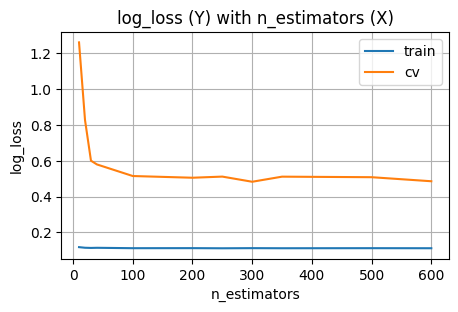

In [11]:
plt.figure(figsize=[5, 3], dpi=100)
plt.title("log_loss (Y) with n_estimators (X)")
plt.plot(l[:, 0], l[:, 1])
plt.plot(l[:, 0], l[:, 2])

plt.ylabel("log_loss")
plt.xlabel("n_estimators")
plt.grid()
plt.legend(["train", "cv"])
plt.show()

We can see that after n_estimators = 100 log_loss did not reduce drastically. Considering 100 as optimal paramter for max_depth

# refit with best model to get feature importance

In [12]:
clf = RandomForestClassifier(n_estimators=100, class_weight=class_weights)
clf = clf.fit(x_train, y_train["Churn"])

In [13]:
df_fimp = pd.DataFrame([x_train.columns, clf.feature_importances_]).T.rename(
    columns={0: "feature", 1: "importance"}
)
df_fimp = df_fimp.sort_values(by=["importance"], ascending=False,).reset_index(
    drop=True
)

In [14]:
# top 5 features
df_fimp.head()

,feature,importance
0,TotalCharges,0.138987
1,MonthlyCharges,0.107332
2,Contract_0,0.0924624
3,cos_day,0.0675705
4,sin_day,0.0674726


We can see that top features for classification according to random forest classifier's feature importance are:
1. 'TotalCharges', 
1. 'MonthlyCharges', 
1. 'Contract_0', 
1. 'cos_day',
1. 'sin_day'

In [15]:
# bottom 5 features
df_fimp.tail()

,feature,importance
28,MultipleLines_0,0.0106358
29,TechSupport_1,0.0105314
30,StreamingTV_1,0.0105304
31,DeviceProtection_0,0.0100448
32,PhoneService,0.00522945


Least important features for classification are:

1. 'MultipleLines_0', 
1. 'TechSupport_1', 
1. 'StreamingTV_1',
1. 'DeviceProtection_0', 
1. 'PhoneService'

Plot of importance of features for classification task using random forest

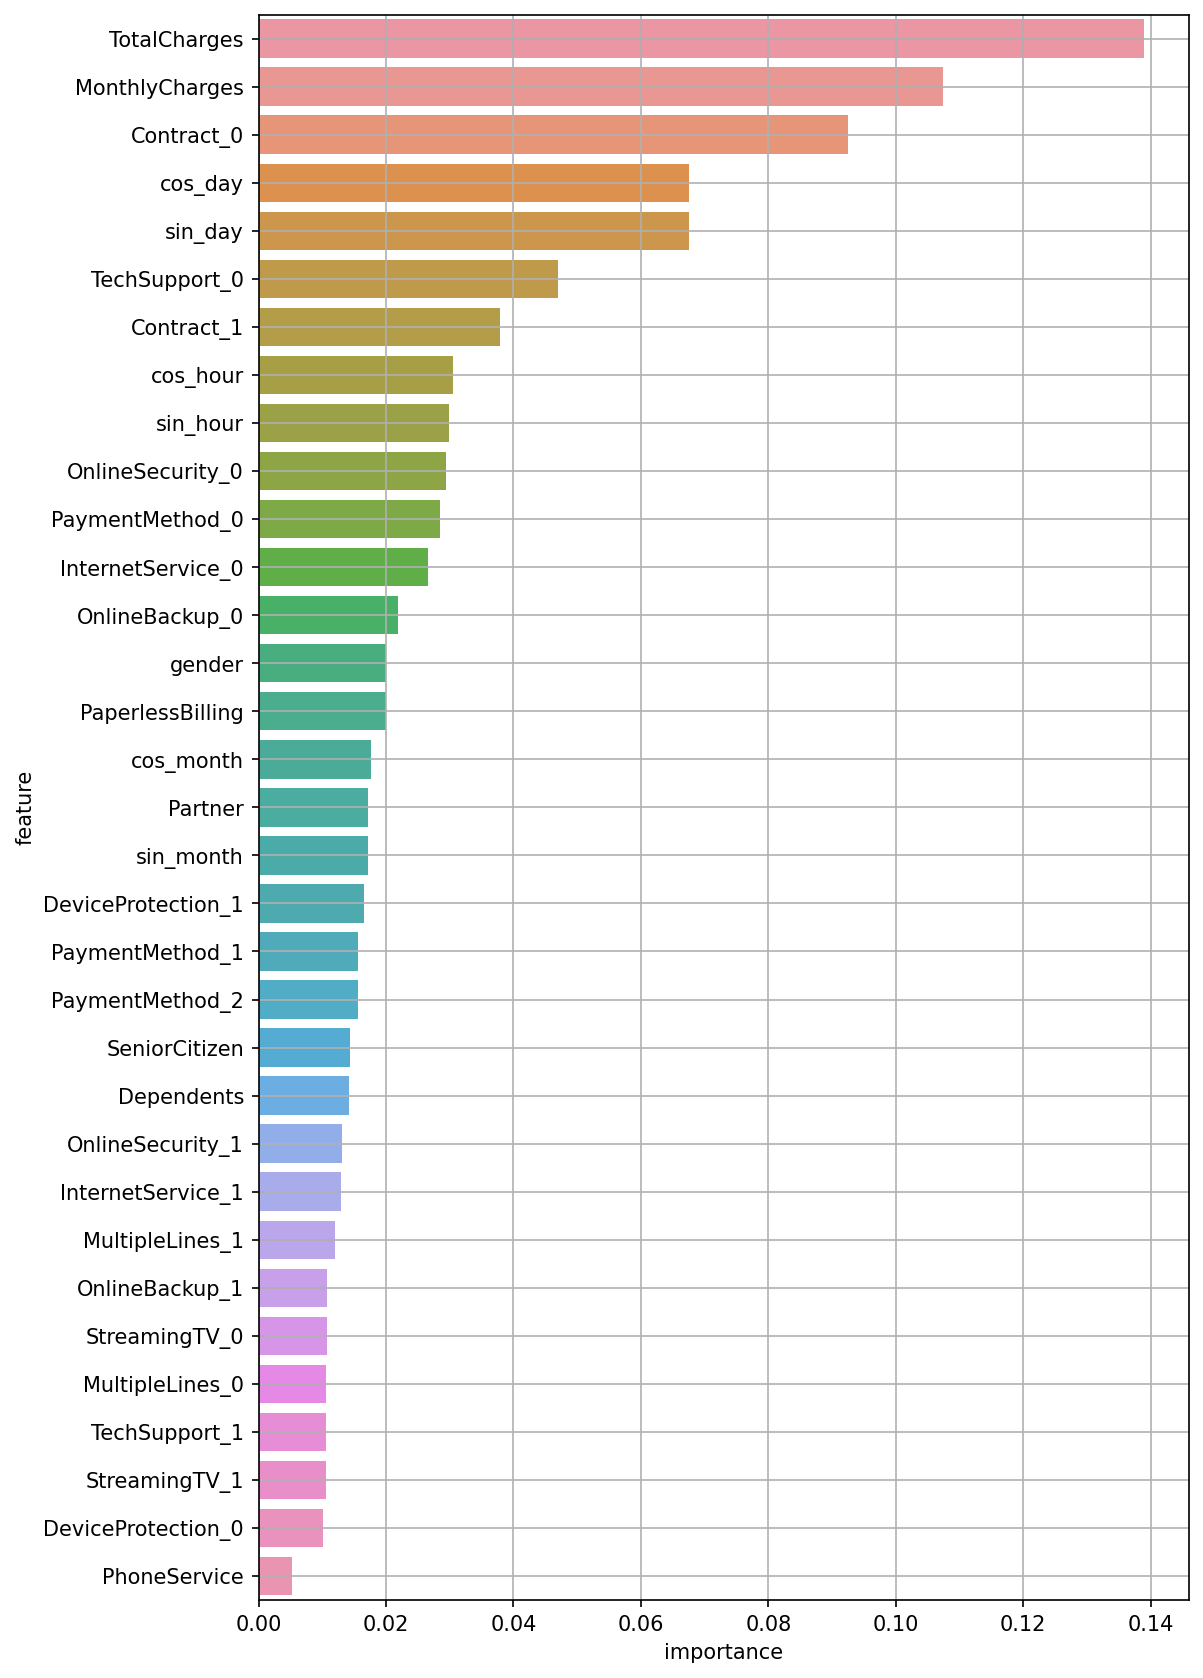

In [16]:
plt.figure(figsize=[8, 14], dpi=150)
sns.barplot(y="feature", x="importance", data=df_fimp.head(50))
plt.grid()
plt.show()

# selecting features

As mentioned in the problem statement selecting top 6 features

In [17]:
selected_features = df_fimp[:6]["feature"].values
selected_features

array(['TotalCharges', 'MonthlyCharges', 'Contract_0', 'cos_day',
       'sin_day', 'TechSupport_0'], dtype=object)

In [18]:
os.makedirs("../data/selected_features_classification/x_train", exist_ok=True)
os.makedirs("../data/selected_features_classification/x_cv", exist_ok=True)
os.makedirs("../data/selected_features_classification/x_test", exist_ok=True)

os.makedirs("../data/selected_features_classification/y_train", exist_ok=True)
os.makedirs("../data/selected_features_classification/y_cv", exist_ok=True)
os.makedirs("../data/selected_features_classification/y_test", exist_ok=True)

In [19]:
x_train[selected_features].to_parquet(
    "../data/selected_features_classification/x_train/data.parquet"
)
x_cv[selected_features].to_parquet(
    "../data/selected_features_classification/x_cv/data.parquet"
)
x_test[selected_features].to_parquet(
    "../data/selected_features_classification/x_test/data.parquet"
)

In [20]:
y_train.to_parquet("../data/selected_features_classification/y_train/data.parquet")
y_cv.to_parquet("../data/selected_features_classification/y_cv/data.parquet")
y_test.to_parquet("../data/selected_features_classification/y_test/data.parquet")